<a href="https://colab.research.google.com/github/shizoda/education/blob/main/machine_learning/unet/unet_lung_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [53]:
import numpy as np
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import torch.nn.functional as F
import pdb

In [54]:
def load_data(h5_file):
    """HDF5ファイルから画像とラベルを読み込む"""
    with h5py.File(h5_file, 'r') as h5f:
        images = h5f['images'][:]
        labels = h5f['labels'][:]
    return images, labels

# データの読み込みと準備
train_images, train_labels = load_data('/content/drive/MyDrive/education/data/msd/lung_2mm/train_patches.h5')
val_images, val_labels = load_data('/content/drive/MyDrive/education/data/msd/lung_2mm/val_patches.h5')
test_images, test_labels = load_data('/content/drive/MyDrive/education/data/msd/lung_2mm/test_patches.h5')

# PyTorchのTensorに変換
train_dataset = TensorDataset(torch.tensor(train_images, dtype=torch.float32), torch.tensor(train_labels, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(val_images, dtype=torch.float32), torch.tensor(val_labels, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(test_images, dtype=torch.float32), torch.tensor(test_labels, dtype=torch.float32))

# DataLoaderの設定
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


In [55]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # 初期チャネル数
        self.base_channels = 16

        # Encoder（ダウンサンプリング）
        self.enc_conv1 = nn.Conv2d(1, self.base_channels, kernel_size=3, padding=1)
        self.enc_conv2 = nn.Conv2d(self.base_channels, self.base_channels * 2, kernel_size=3, padding=1)
        self.enc_conv3 = nn.Conv2d(self.base_channels * 2, self.base_channels * 4, kernel_size=3, padding=1)

        # Max Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Decoder（アップサンプリング）
        self.dec_upconv3 = nn.ConvTranspose2d(self.base_channels * 4, self.base_channels * 2, kernel_size=2, stride=2)
        self.dec_conv3 = nn.Conv2d(self.base_channels * 4, self.base_channels * 2, kernel_size=3, padding=1)
        self.dec_upconv2 = nn.ConvTranspose2d(self.base_channels * 2, self.base_channels, kernel_size=2, stride=2)
        self.dec_conv2 = nn.Conv2d(self.base_channels * 2, self.base_channels, kernel_size=3, padding=1)

        # Final Layer
        self.final_conv = nn.Conv2d(self.base_channels, 1, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = F.relu(self.enc_conv1(x))
        enc2 = F.relu(self.enc_conv2(self.pool(enc1)))
        enc3 = F.relu(self.enc_conv3(self.pool(enc2)))

        # Decoder
        dec3 = torch.cat((F.relu(self.dec_upconv3(enc3)), enc2), dim=1)
        dec3 = F.relu(self.dec_conv3(dec3))
        dec2 = torch.cat((F.relu(self.dec_upconv2(dec3)), enc1), dim=1)
        dec2 = F.relu(self.dec_conv2(dec2))

        # Final segmented output
        out = torch.sigmoid(self.final_conv(dec2))
        return out


In [56]:
# モデル、オプティマイザー、損失関数の定義
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)

        return 1 - dice

# 重み付きクロスエントロピー損失を定義
criterion = DiceLoss()

In [57]:
def train(model, device, train_loader, optimizer, criterion):
    """トレーニングステップ"""
    model.train()
    total_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def validate(model, device, val_loader, criterion):
    """バリデーションステップ"""
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(val_loader)

In [58]:
# トレーニングとバリデーション
num_epochs = 100
best_val_loss = float('inf')
train_losses, val_losses = [], []
no_improve_count = 0  # 改善されない回数をカウント

for epoch in range(num_epochs):
    train_loss = train(model, device, train_loader, optimizer, criterion)
    val_loss = validate(model, device, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve_count = 0  # 改善されたのでカウントをリセット
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        no_improve_count += 1  # 改善されない回数をインクリメント
        if no_improve_count >= 10:  # 10回連続で改善されない場合
            print('Early stopping')
            break



Epoch 1/100, Train Loss: 0.9152, Val Loss: 0.9282
Epoch 2/100, Train Loss: 0.9150, Val Loss: 0.9278
Epoch 3/100, Train Loss: 0.9146, Val Loss: 0.9273
Epoch 4/100, Train Loss: 0.9118, Val Loss: 0.9266
Epoch 5/100, Train Loss: 0.9126, Val Loss: 0.9256
Epoch 6/100, Train Loss: 0.9098, Val Loss: 0.9242
Epoch 7/100, Train Loss: 0.9042, Val Loss: 0.9222
Epoch 8/100, Train Loss: 0.9055, Val Loss: 0.9198
Epoch 9/100, Train Loss: 0.9007, Val Loss: 0.9182
Epoch 10/100, Train Loss: 0.9014, Val Loss: 0.9172
Epoch 11/100, Train Loss: 0.8954, Val Loss: 0.9161
Epoch 12/100, Train Loss: 0.8992, Val Loss: 0.9147
Epoch 13/100, Train Loss: 0.8950, Val Loss: 0.9132
Epoch 14/100, Train Loss: 0.8937, Val Loss: 0.9116
Epoch 15/100, Train Loss: 0.8867, Val Loss: 0.9099
Epoch 16/100, Train Loss: 0.8890, Val Loss: 0.9081
Epoch 17/100, Train Loss: 0.8854, Val Loss: 0.9053
Epoch 18/100, Train Loss: 0.8799, Val Loss: 0.9016
Epoch 19/100, Train Loss: 0.8728, Val Loss: 0.8968
Epoch 20/100, Train Loss: 0.8636, Val Lo

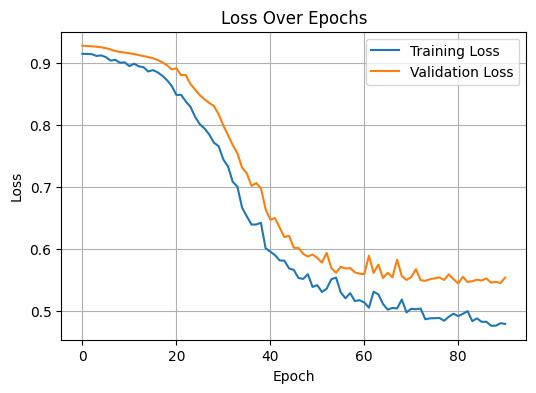

In [59]:
def plot_history(train_losses, val_losses):
    """学習履歴をプロット"""
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# 学習履歴のプロット
plot_history(train_losses, val_losses)


In [60]:
import random

def dice_coeff(pred, target):
    """Dice係数を計算"""
    smooth = 1.
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

# モデルを評価モードに設定
model.eval()
dice_scores = []

# テストデータに対する精度の計算
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        dice_scores.append(dice_coeff(outputs, labels))

# 平均Diceスコア
mean_dice = torch.mean(torch.tensor(dice_scores))
print(f'Mean Dice Score on Test Data: {mean_dice.item()}')

Mean Dice Score on Test Data: 0.42476266622543335


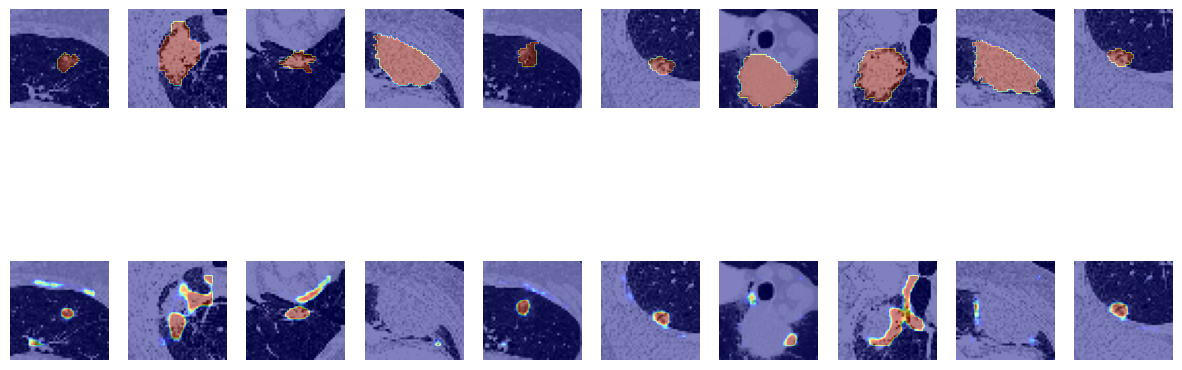

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# ランダムに10枚の画像を選択して可視化
indices = random.sample(range(len(test_dataset)), 10)
plt.figure(figsize=(15, 6))

for i, idx in enumerate(indices, 1):
    image, label = test_dataset[idx]
    image, label = image.to(device).unsqueeze(0), label.to(device).unsqueeze(0)
    pred = model(image).squeeze(0).cpu()

    # 1行目に実際のラベルを表示
    plt.subplot(2, 10, i)
    plt.imshow(image.cpu().squeeze(0)[0,...], cmap='gray')
    plt.imshow(label.cpu().squeeze(0)[0,...], cmap='jet', alpha=0.5)
    plt.axis('off')

    # 2行目に予測されたセグメンテーションマスクを表示
    plt.subplot(2, 10, i + 10)
    plt.imshow(image.cpu().squeeze(0)[0,...], cmap='gray')
    plt.imshow(pred.cpu().detach().numpy().squeeze(0), cmap='jet', alpha=0.5)
    plt.axis('off')

plt.show()
